In [6]:
%load_ext nb_black
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco

import pandas_datareader as pdr

plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [7]:
stocks = ['TMUS', 'FB', 'COP', 'BABA', 'AMZN', 'MSFT', 'LMT', 'FDX', 'TGTX', 'TSLA']

<IPython.core.display.Javascript object>

In [8]:
df = pd.DataFrame()

for ticker in stocks:
    try:
        df[ticker] = pdr.get_data_yahoo(ticker, "01 01 2015", "02 08 2021")['Adj Close']
        print(ticker)
    except:
        print(ticker, "not found")
        pass

TMUS
FB
COP
BABA
AMZN
MSFT
LMT
FDX
TGTX
TSLA


<IPython.core.display.Javascript object>

In [9]:
table = df

<IPython.core.display.Javascript object>

In [10]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((len(table.columns), num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(table.columns))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

<IPython.core.display.Javascript object>

In [11]:
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0147

<IPython.core.display.Javascript object>

In [12]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate, capital):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    #max_sharpe_idx = np.argmax(results[1])
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation['dv_allocation'] = [round(i*capital/100, 2) for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation['dv_allocation'] = [round(i*capital/100, 2) for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print( min_vol_allocation)

    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)
    return max_sharpe_allocation, min_vol_allocation

<IPython.core.display.Javascript object>

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.36
Annualised Volatility: 0.23


                 TMUS    FB   COP   BABA    AMZN   MSFT     LMT    FDX  TGTX  \
allocation      13.08   3.7  0.03   1.95   23.69   6.34   26.56   2.11   1.7   
dv_allocation  170.04  48.1  0.39  25.35  307.97  82.42  345.28  27.43  22.1   

                 TSLA  
allocation      20.84  
dv_allocation  270.92  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.24
Annualised Volatility: 0.2


                 TMUS     FB   COP   BABA  AMZN    MSFT     LMT     FDX  TGTX  \
allocation      20.47   2.89   1.6   7.07   2.4   16.32   35.38    9.94  0.43   
dv_allocation  266.11  37.57  20.8  91.91  31.2  212.16  459.94  129.22  5.59   

               TSLA  
allocation      3.5  
dv_allocation  45.5  


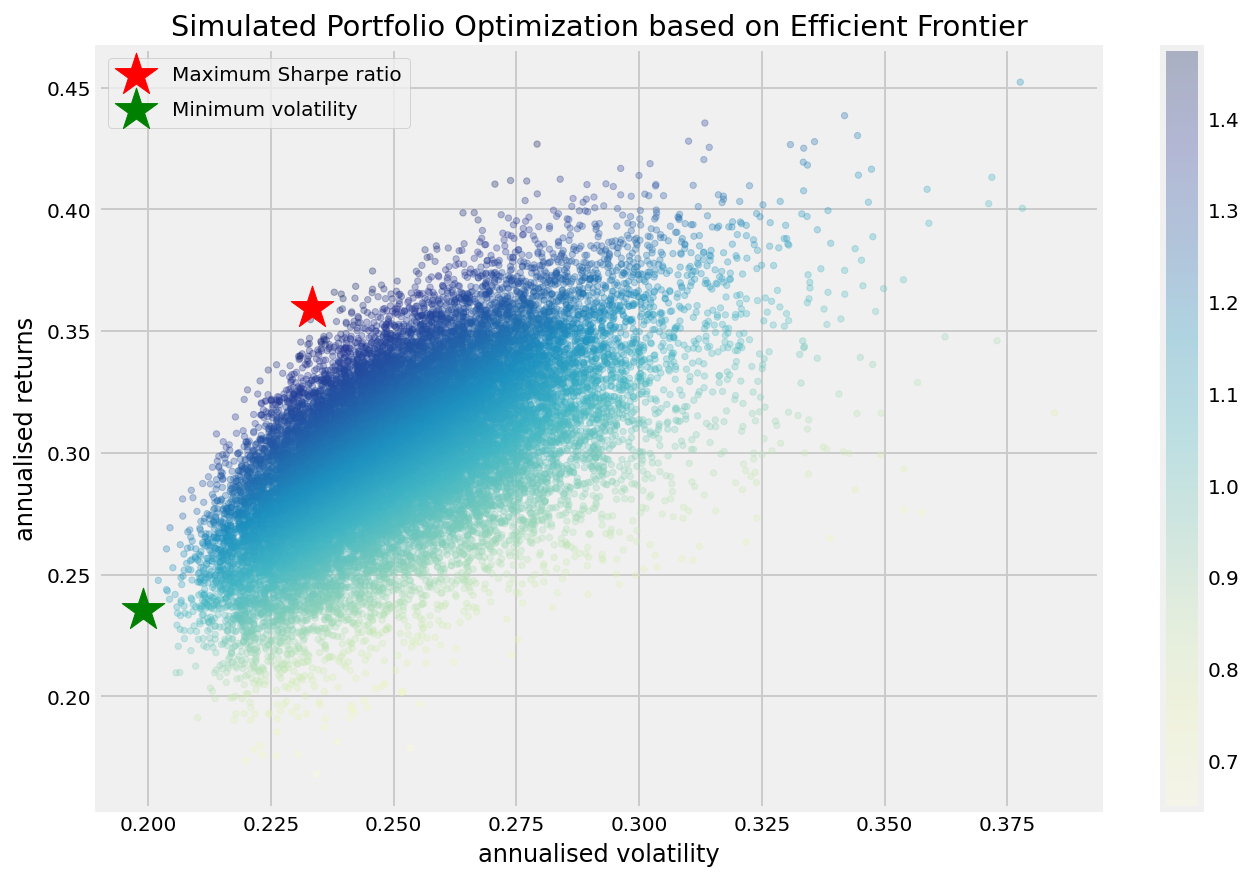

<IPython.core.display.Javascript object>

In [13]:
capital_size = 1300 # USD
sh, vol = display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate, capital_size)

In [14]:
tradings_size = 100
account_init = 100

pnl_prob = [np.around((np.random.rand()*2 - 1), decimals = 2) for i in range(tradings_size)]

<IPython.core.display.Javascript object>

In [15]:
single_pnl = np.around((np.random.rand()*2 - 1)/10, decimals = 2)

curr_acc = account_init + account_init*single_pnl

<IPython.core.display.Javascript object>

In [16]:
round_counter = 0
while(curr_acc < 150 and curr_acc > 0):
    #print(round_counter)
    round_counter += 1
    single_pnl = np.around((np.random.rand()*2 - 1)/10, decimals = 2)
    curr_acc = curr_acc + curr_acc*single_pnl

print(round_counter)

107


<IPython.core.display.Javascript object>